# Applying the autoencoder model trained by the Catalina lcs to simulated lcs

We showed the autoencoder model can reproduce the light curves with uneven-sampling and un-uniformed errors fairly well. The $\chi^2_{\mathrm{red}}$ value for the most of light curves is close to one, while lcs with relatively large $\chi^2_{\mathrm{red}}$ value seemes to be a blended source (or might be an interesting object to investigate). 

In this notebook, we investigate the property of the embedded features which is calculated by the autoencoder model. As the first step of this, we investigated the correlation between the embedded features and the timescale of the variation $\tau$ and the amplitude of the short timescale variation $\sigma$ by using simulated light curves generated by OU model.

In [1]:
import sys
sys.path.append('./IrregularTimeSeriesAutoencoder')
import numpy as np
import pandas as pd
from keras.layers import (Input, Dense, TimeDistributed, LSTM, GRU, Dropout, merge,
                          Flatten, RepeatVector, Recurrent, Bidirectional, SimpleRNN)
from keras.models import Model
import keras_util as ku
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display_png, display_pdf
import subprocess

Using TensorFlow backend.
/Users/tachibana/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def encoder(model_input, layer, size, num_layers, drop_frac=0.25, output_size=None,
            bidirectional=False, **parsed_args):
    if output_size is None:
        output_size = size
    encode = model_input
    for i in range(num_layers):
        wrapper = Bidirectional if bidirectional else lambda x: x
        encode = wrapper(layer(size, name='encode_{}'.format(i),
                               return_sequences=(i < num_layers - 1)))(encode)
        if drop_frac > 0.0:
            encode = Dropout(drop_frac, name='drop_encode_{}'.format(i))(encode)
    encode = Dense(output_size, activation='linear', name='encoding')(encode)
    return encode

def decoder(encode, layer, n_step, size, num_layers, drop_frac=0.25, aux_input=None,
            bidirectional=False, **parsed_args):
    
    decode = RepeatVector(n_step, name='repeat')(encode)
    if aux_input is not None:
        decode = merge([aux_input, decode], mode='concat')

    for i in range(num_layers):
        if drop_frac > 0.0 and i > 0:  # skip these for first layer for symmetry
            decode = Dropout(drop_frac, name='drop_decode_{}'.format(i))(decode)
        wrapper = Bidirectional if bidirectional else lambda x: x
        decode = wrapper(layer(size, name='decode_{}'.format(i),
                               return_sequences=True))(decode)

    decode = TimeDistributed(Dense(1, activation='linear'), name='time_dist')(decode)
    return decode

def load_lcs(pass_to_lc_dir):
    command = 'ls ' + str(pass_to_lc_dir)
    lc_files = subprocess.run(command, stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8').split('\n')
    del lc_files[len(lc_files)-1]
    print('Loading %d data:'%len(lc_files))
    X = [np.r_[np.array(pd.read_csv('./lcs/'+str(lc_files[i]), header=None, sep=' ')).tolist()] for i in range(len(lc_files))]
    print('Finish.')
    return  X

def preprocess(X_raw, m_max=np.inf):
    X = X_raw.copy()
    wrong_units =  np.all(np.isnan(X[:, :, 1])) | (np.nanmax(X[:, :, 1], axis=1) > m_max)
    X = X[~wrong_units, :, :]
    X[:, :, 0] = ku.times_to_lags(X[:, :, 0])
    means = np.atleast_2d(np.nanmean(X[:, :, 1], axis=1)).T
    X[:, :, 1] -= means
    scales = np.atleast_2d(np.nanstd(X[:, :, 1], axis=1)).T
    X[:, :, 1] /= scales
    errors = X[:, :, 2] / scales
    X = X[:, :, :2]
    return X, means, scales, errors, wrong_units

Loading the Catalina QSO's light curve. 

In [3]:
X_list = load_lcs('./lcs/')

Loading 4227 data:
Finish.


In [4]:
from keras.preprocessing.sequence import pad_sequences
X_raw = pad_sequences(X_list, value=np.nan, dtype='float', padding='post')

In [5]:
X, means, scales, errors, wrong_units = preprocess(X_raw)

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


In [6]:
nan_mask = np.where((~np.isnan(errors.flatten()))&((~np.isnan(X[:, :, 0].flatten()))))

data_len_arr = np.empty(len(X))
obs_len_arr = np.empty(len(X))
for i in range(0, len(X)):
    data_len_arr[i] = len(X_list[i])
    obs_len_arr[i] = np.nanmax(X_list[i][:,0]) - np.nanmin(X_list[i][:,0])

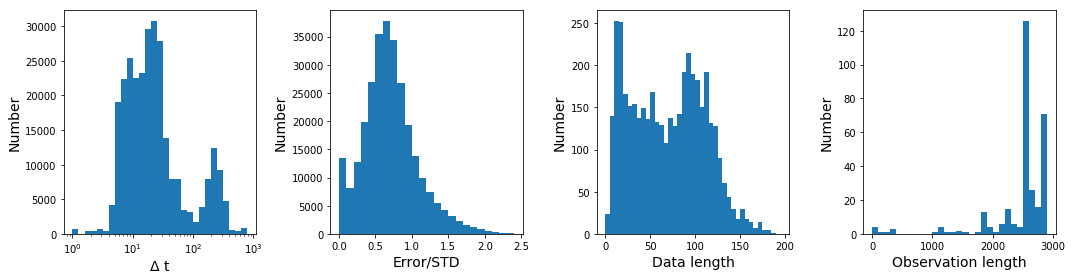

In [7]:
plt.figure(figsize=(15, 4))
plt.subplot(1,4,1)
plt.hist(X[:, :, 0].flatten()[nan_mask], bins=10**np.arange(0,3,0.1))
plt.xlabel(r'$\Delta$ t', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.xscale('log')
plt.subplot(1,4,2)
plt.hist(errors.flatten()[nan_mask], bins=np.arange(0,2.5,0.1))
plt.xlabel('Error/STD', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.subplot(1,4,3)
plt.hist(data_len_arr, bins=np.arange(0,200, 5))
plt.xlabel('Data length', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.subplot(1,4,4)
plt.hist(obs_len_arr, bins=np.arange(0,3000, 100))
plt.xlabel('Observation length', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.tight_layout()
plt.show()

### Generating light curves based on OU process with even sampling

We first check the performance of the autoencoder model by using even-sampling OU process light curvre. 
The $\Delta t$, the number of the data point in a light curve, and the length of the observation is determined based on the Catalina dataset.

In [8]:
import pyprocess as pypr

In [42]:
N_sim = int(1e2) # Number of the light curves 
tau_list = 10**(np.random.rand(N_sim)*1.5+2.5) #tau is in range between 10**1.5 and 10**4.0 
Y = pd.DataFrame()
T = pd.DataFrame()

def make_monk_lc(tau, error=np.nanmedian(errors.flatten())):
    while 1:
        #t = random_times(1, n_min = 10, n_max = np.nanmax(data_len_arr)*2, t_shape=0.5, t_scale=10)
        t = [np.linspace(0, 2900, 188)] # even sampling
        if (2500 < np.max(t[0]) - np.min(t[0]))&(np.max(t[0]) - np.min(t[0]) < 3000):
            mu = 0
            sigma = np.sqrt(1/tau/10) # sigma seems to be correlated with tau systematically (Graham et al. 2011)
            theta = 1/tau
            err_to_std = error
            out_tbl = pd.DataFrame()
            oupr = pypr.OU_process(theta=theta, mu=mu, sigma=sigma)
            y = oupr.sample_path(t[0], N=1)[0]
            y = y - np.mean(y)
            y = y/np.std(y)
            y = y + np.random.randn(len(y))*err_to_std
            out_tbl[0] = t[0] 
            out_tbl[1] = y
            out_tbl[2] = np.ones(len(t[0]))*err_to_std
            return(out_tbl)

Generating 100 light curves. 

In [43]:
X_sim_list = [np.r_[np.array(make_monk_lc(tau)).tolist()] for tau in tau_list]

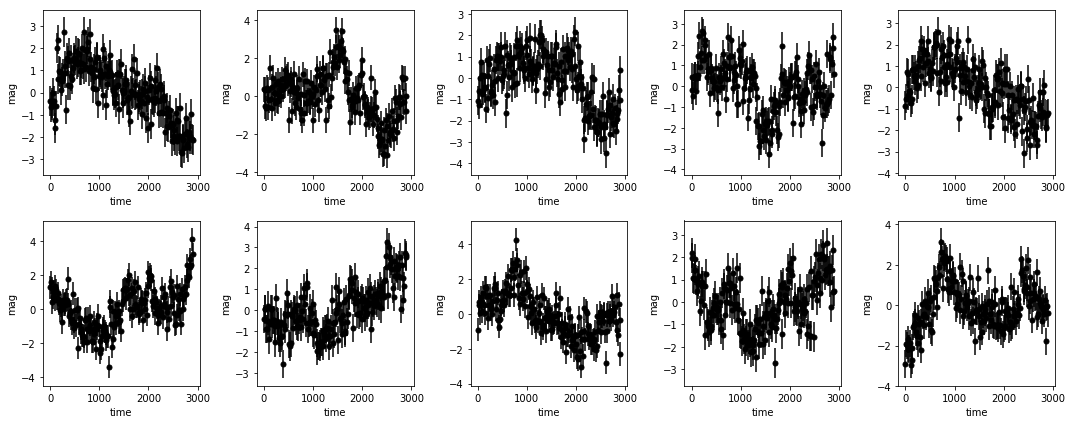

In [44]:
plt.figure(figsize=(15, 6))

for i in range(5):
    plt.subplot(2, 5 ,i+1)
    plt.errorbar(X_sim_list[i][:,0], X_sim_list[i][:,1], yerr=X_sim_list[i][:,2], fmt='ko', markersize=5)
    plt.xlabel('time')
    plt.ylabel('mag')
for i in range(5):
    plt.subplot(2, 5 ,i+1+5)
    plt.errorbar(X_sim_list[i+5][:,0], X_sim_list[i+5][:,1], yerr=X_sim_list[i+5][:,2], fmt='ko', markersize=5)
    plt.xlabel('time')
    plt.ylabel('mag')

plt.tight_layout()
plt.show()

The figure shows examples of simulated light curves. The observation length and the number of the data point is fixed to 2800 days and 188 respectively. 

In [45]:
from keras.preprocessing.sequence import pad_sequences
X_sim_raw = pad_sequences(X_sim_list, value=np.nan, dtype='float', padding='post', maxlen=len(X[0]))

In [46]:
X_sim, means_sim, scales_sim, errors_sim, wrong_units_sim = preprocess(X_sim_raw)

In [47]:
nan_sim_mask = np.where(~np.isnan(X_sim[:, :, 0].flatten()))

data_sim_len_arr = np.empty(len(X_sim))
obs_sim_len_arr = np.empty(len(X_sim))
for i in range(0, len(X_sim)):
    data_sim_len_arr[i] = len(X_sim_list[i])
    obs_sim_len_arr[i] = np.nanmax(X_sim_list[i][:,0]) - np.nanmin(X_sim_list[i][:,0])

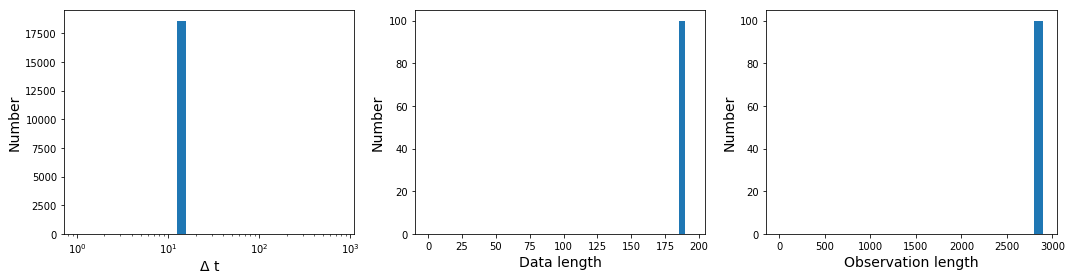

In [48]:
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.hist(X_sim[:, :, 0].flatten()[nan_sim_mask], bins=10**np.arange(0,3,0.1))
plt.xlabel(r'$\Delta$ t', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.xscale('log')
plt.subplot(1,3,2)
plt.hist(data_sim_len_arr, bins=np.arange(0,200, 5))
plt.xlabel('Data length', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.subplot(1,3,3)
plt.hist(obs_sim_len_arr, bins=np.arange(0,3000, 100))
plt.xlabel('Observation length', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.tight_layout()
plt.show()

### Applying the autoencoder model to the simulated light curves

In [49]:
main_input = Input(shape=(X_sim.shape[1], 2), name='main_input') #(lag, mag)
aux_input = Input(shape=(X_sim.shape[1], 1), name='aux_input') #(lag)
model_input = [main_input, aux_input]

In [50]:
sample_weight = 1. / errors_sim
sample_weight[np.isnan(sample_weight)] = 0.0
X_sim[np.isnan(X_sim)] = 0.

We use the autoencoder model with folloeing parameters: 
 
Number of units within each hidden layer: 64

Number of hidden layers: 5

Size of encoding layer=16

Dropout rate = 0.25. 

In [51]:
encode = encoder(main_input, layer=GRU, size=64, num_layers=5, output_size=16, drop_frac=0.25, bidirectional=True)
decode = decoder(encode, layer=GRU, size=64, num_layers=5,  n_step=X_sim.shape[1], drop_frac=0.25, aux_input=aux_input)
model = Model(model_input, decode)

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [52]:
lr = 1e-3
from keras.optimizers import Adam
optimizer = Adam(lr=lr)
model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')

In [53]:
model.load_weights('keras_logs/test_ft1m03_64_5_16/weights.h5')

In [54]:
encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
decode_model = Model(input=model.input, output=model.output)
encoding = encode_model.predict({'main_input': X_sim, 'aux_input': np.delete(X_sim, 1, axis=2)})
decoding = decode_model.predict({'main_input': X_sim, 'aux_input': np.delete(X_sim, 1, axis=2)})

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ti...)`
  


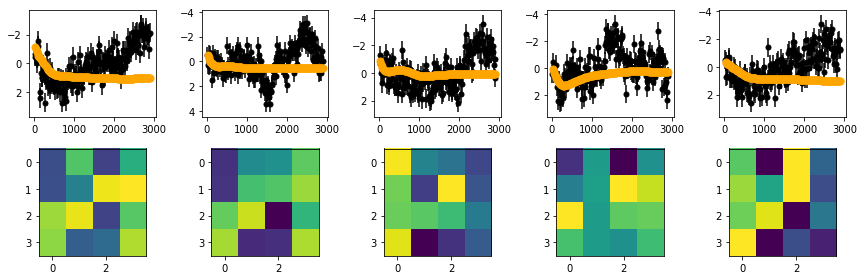

Upper panels: Input light curves (black points) and decoded light curves (orange points) 

Lower panels: Encoded 8 features


In [55]:
i = 0 #init num of the plotting data
k=0 #initialize the counter
fignum = 5
plt.figure(figsize=(12, 4))
#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    plt.errorbar(X_sim_raw[num][:,0], X_sim_raw[num][:,1], yerr=X_sim_raw[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_sim[num][:, 0][X_sim[num][:, 0]>0])+X_sim_raw[num][0,0], 
             decoding[num][X_sim[num][:, 0]>0]*scales_sim[num]+means_sim[num], fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    k += 1
#plotting encoded features
k=0
for num in range(i+fignum,i+2*fignum):
    plt.subplot(2, fignum, k+1+fignum)
    plt.imshow(encoding[num].reshape(4,4), vmin=-2, vmax=2, cmap='viridis_r')
    k += 1
plt.tight_layout()
plt.savefig('Catalina_modeled_lc_encoded_features_train.pdf', pad_inches=0.5)
plt.show()

print("""Upper panels: Input light curves (black points) and decoded light curves (orange points) \n
Lower panels: Encoded 8 features""")

It is interesting that the autoencoder model trained by uneven-sampling dataset cannot reproduce the even-sampling variation well. 

### Generating light curves based on OU process with the sampling interval same as the Catalina dataset

We showed that the autoencoder model trained with catalina dataset cannot model the even-sampling OU process. We next try to apply the autoencoder model to OU process light curves with same sampling as the Catalina dataset.

In [110]:
N_sim = 10*len(X)
tau_list = 10**(np.random.rand(N_sim)*2+2) #tau is in range between 10**2 and 10**4.0 
#sigma_list = 10**(-np.random.rand(N_sim)*1 - 1.5)
Y = pd.DataFrame()
T = pd.DataFrame()

def make_monk_lc(t, tau, error=np.nanmedian(errors.flatten())):
    mu = 0
    sigma = np.sqrt(1/tau/10)
    theta = 1/tau
    err_to_std = error
    out_tbl = pd.DataFrame()
    oupr = pypr.OU_process(theta=theta, mu=mu, sigma=sigma)
    y = oupr.sample_path(t, N=1)[0]
    y = y - np.mean(y)
    y = y/np.std(y)
    y = y + np.random.randn(len(y))*err_to_std
    out_tbl[0] = t
    out_tbl[1] = y
    out_tbl[2] = np.ones(len(t))*err_to_std
    return(out_tbl)

The numbers of light curves and the sampling interval is fixed to be same as the Catalina dataset. 

In [111]:
X_sim_list = [np.r_[np.array(make_monk_lc(X_list[i%len(X_list)][:,0], tau)).tolist()] for i, tau in enumerate(tau_list)]

/Users/tachibana/Documents/AutoEncoder_180312/pyprocess.py:841: RuntimeWarning: overflow encountered in exp
  sigma = np.sqrt(self.sigma**2*(1-np.exp(-2*self.theta*deltas))/(2*self.theta))
/Users/tachibana/Documents/AutoEncoder_180312/pyprocess.py:841: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(self.sigma**2*(1-np.exp(-2*self.theta*deltas))/(2*self.theta))
/Users/tachibana/Documents/AutoEncoder_180312/pyprocess.py:843: RuntimeWarning: overflow encountered in exp
  mu = self.mu + np.exp(-self.theta*delta)*(x-self.mu)
/Users/tachibana/Documents/AutoEncoder_180312/pyprocess.py:843: RuntimeWarning: invalid value encountered in multiply
  mu = self.mu + np.exp(-self.theta*delta)*(x-self.mu)
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


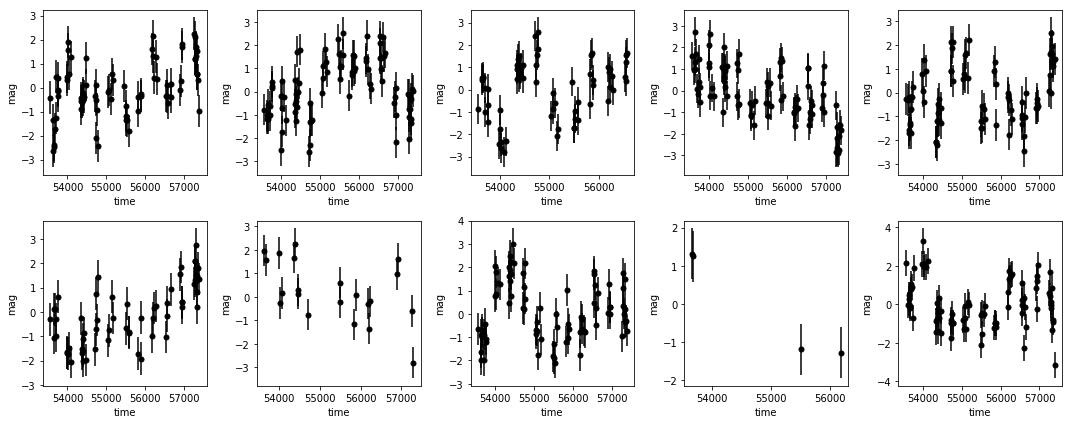

In [112]:
plt.figure(figsize=(15, 6))

for i in range(5):
    plt.subplot(2, 5 ,i+1)
    plt.errorbar(X_sim_list[i][:,0], X_sim_list[i][:,1], yerr=X_sim_list[i][:,2], fmt='ko', markersize=5)
    plt.xlabel('time')
    plt.ylabel('mag')
for i in range(5):
    plt.subplot(2, 5 ,i+1+5)
    plt.errorbar(X_sim_list[i+5][:,0], X_sim_list[i+5][:,1], yerr=X_sim_list[i+5][:,2], fmt='ko', markersize=5)
    plt.xlabel('time')
    plt.ylabel('mag')

plt.tight_layout()
plt.show()

This figure shows examples of the simulated light curve. 

In [113]:
X_sim_raw = pad_sequences(X_sim_list, value=np.nan, dtype='float', padding='post', maxlen=len(X[0]))
X_sim, means_sim, scales_sim, errors_sim, wrong_units_sim = preprocess(X_sim_raw)

nan_sim_mask = np.where(~np.isnan(X_sim[:, :, 0].flatten()))

data_sim_len_arr = np.empty(len(X_sim))
obs_sim_len_arr = np.empty(len(X_sim))
for i in range(0, len(X_sim)):
    data_sim_len_arr[i] = len(X_sim_list[i])
    obs_sim_len_arr[i] = np.nanmax(X_sim_list[i][:,0]) - np.nanmin(X_sim_list[i][:,0])

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: All-NaN slice encountered
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


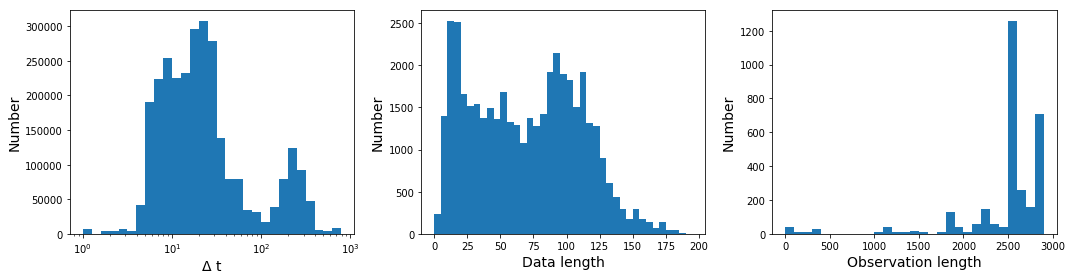

In [114]:
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.hist(X_sim[:, :, 0].flatten()[nan_sim_mask], bins=10**np.arange(0,3,0.1))
plt.xlabel(r'$\Delta$ t', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.xscale('log')
plt.subplot(1,3,2)
plt.hist(data_sim_len_arr, bins=np.arange(0,200, 5))
plt.xlabel('Data length', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.subplot(1,3,3)
plt.hist(obs_sim_len_arr, bins=np.arange(0,3000, 100))
plt.xlabel('Observation length', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.tight_layout()
plt.show()

The $\Delta t$, the number of the data point in each light curve, and the length of the observation is exactly same as the Catalina dataset. 

In [115]:
main_input = Input(shape=(X_sim.shape[1], 2), name='main_input') #(lag, mag)
aux_input = Input(shape=(X_sim.shape[1], 1), name='aux_input') #(lag)
model_input = [main_input, aux_input]
sample_weight = 1. / errors_sim
sample_weight[np.isnan(sample_weight)] = 0.0
X_sim[np.isnan(X_sim)] = 0.

In [116]:
encode = encoder(main_input, layer=GRU, size=64, num_layers=5, output_size=16, drop_frac=0.25, bidirectional=True)
decode = decoder(encode, layer=GRU, size=64, num_layers=5,  n_step=X_sim.shape[1], drop_frac=0.25, aux_input=aux_input)
model = Model(model_input, decode)
model.compile(optimizer=optimizer, loss='mse',  sample_weight_mode='temporal')
model.load_weights('keras_logs/test_ft1m03_64_5_16/weights.h5')

encode_model = Model(input=model.input, output=model.get_layer('encoding').output)
decode_model = Model(input=model.input, output=model.output)
encoding = encode_model.predict({'main_input': X_sim, 'aux_input': np.delete(X_sim, 1, axis=2)})
decoding = decode_model.predict({'main_input': X_sim, 'aux_input': np.delete(X_sim, 1, axis=2)})

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("en...)`
  import sys
/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ti...)`
  


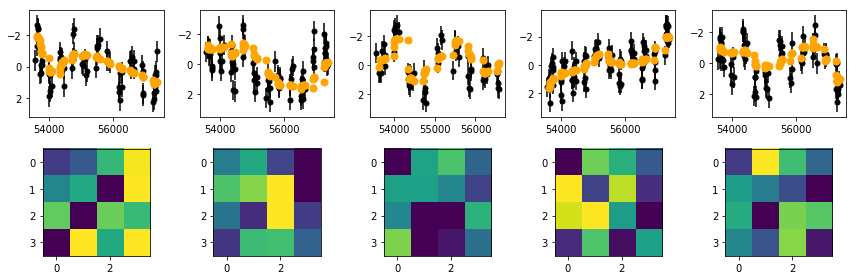

Upper panels: Simulated light curves (black points) and decoded light curves (orange points) 

Lower panels: Encoded 8 features


In [117]:
i = 0 #init num of the plotting data
k=0 #initialize the counter
fignum = 5
plt.figure(figsize=(12, 4))
#plotting raw-lightcurves and the decoded lightcurves 
for num in range(i,i+fignum):
    plt.subplot(2, fignum, k+1)
    plt.errorbar(X_sim_raw[num][:,0], X_sim_raw[num][:,1], yerr=X_sim_raw[num][:, 2], fmt='o', color='black', ms=5)
    plt.errorbar(np.cumsum(X_sim[num][:, 0][X_sim[num][:, 0]>0])+X_sim_raw[num][0,0], 
             decoding[num][X_sim[num][:, 0]>0]*scales_sim[num]+means_sim[num], fmt='o', color='orange', ms=7)
    plt.ylim(plt.ylim()[::-1])
    k += 1
#plotting encoded features
k=0
for num in range(i+fignum,i+2*fignum):
    plt.subplot(2, fignum, k+1+fignum)
    plt.imshow(encoding[num].reshape(4,4), vmin=-2, vmax=2, cmap='viridis_r')
    k += 1
plt.tight_layout()
plt.savefig('Catalina_modeled_lc_encoded_features_train.pdf', pad_inches=0.5)
plt.show()

print("""Upper panels: Simulated light curves (black points) and decoded light curves (orange points) \n
Lower panels: Encoded 8 features""")

The simulated light curves looks reproduced nicely. 

In [121]:
def calc_redchisq(x, x_pred, weight):
    mask =  (~np.isnan(weight))
    out = np.sum(((x[mask]-x_pred[mask])*weight[mask])**2)/len(weight[mask])
    return out

RedChiSq = []
print('Caluculating reduced chi-square for each source')
for m in range(0, len(X_sim_raw)):
    if m%100 == 0:
        print('.', end='')
    RedChiSq.append(calc_redchisq(X_sim[m][:,1]*scales_sim[m]+means_sim[m], 
                                  np.squeeze(decoding[m]*scales_sim[m]+means_sim[m]), 1/X_sim_raw[m][:,2]))

Caluculating reduced chi-square for each source
.......................................................................................................................................................................................................................................................................................................................................................................................................................................

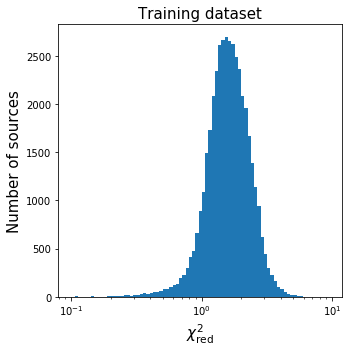

In [136]:
plt.figure(figsize=(5,5))
plt.hist(np.array(RedChiSq)[~np.isnan(RedChiSq)], 
         bins=10**np.arange(-1, 1, 0.025))
plt.xscale('log')
plt.xlabel(r'$\chi_{{\rm red}}^2$', fontsize=15)
plt.ylabel('Number of sources', fontsize=15)
plt.title('Training dataset', fontsize=15)
plt.tight_layout()

$\chi^2_{\mathrm{red}}$ is close to one. 
The value might be depended on the error size we used when we create the light curve (future work).

### Rreproducing $\tau$ from encorded features by the random forest regression

In [123]:
encoding_train = encoding[0:int(0.8*len(encoding))]
encoding_val = encoding[int(0.8*len(encoding)):len(encoding)]
tau_train = tau_list[0:int(0.8*len(tau_list))]
tau_val = tau_list[int(0.8*len(tau_list)):len(tau_list)]
sigma_train = sigma_list[0:int(0.8*len(sigma_list))]
sigma_val = sigma_list[int(0.8*len(sigma_list)):len(sigma_list)]

We use 80% data for training, and 20% data for validation.

In [137]:
from sklearn.ensemble import RandomForestRegressor

In [138]:
regr = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [139]:
regr.fit(encoding_train, np.log10(tau_train))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

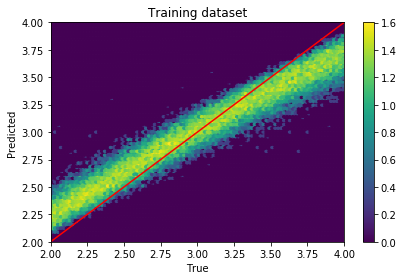

In [143]:
plt.hexbin(np.log10(tau_train), regr.predict(encoding_train), extent=[2,4,2,4], gridsize=100, bins='log')
plt.plot([0, 4], [0, 4], color='red')
plt.colorbar()
plt.xlim(2, 4)
plt.ylim(2, 4)
plt.title('Training dataset')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()

For the training dataset, 
the predicted value has a linear relationship with the true value 
(we cannot say the $\tau$ is predicted correctly though). 

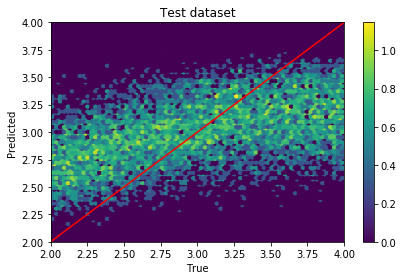

In [146]:
plt.hexbin(np.log10(tau_val), regr.predict(encoding_val), extent=[2,4,2,4], gridsize=75, bins='log')
plt.plot([0, 4], [0, 4], color='red')
plt.colorbar()
plt.xlim(2, 4)
plt.ylim(2, 4)
plt.title('Test dataset')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()

For the validation dataset, the prediction is not good. However, considering that the observation length should be longer than $10\tau$ to reproduce $\tau$ correctly, the result seems reasonable. 